In [1]:
import pandas      as pd
import numpy       as np
from   datetime    import date, timedelta
from   scipy.stats import t
import yfinance    as yf
import matplotlib.pyplot as plt
import gc; gc.enable()

from sklearn.metrics      import classification_report, confusion_matrix, \
                                 accuracy_score, balanced_accuracy_score, \
                                 roc_auc_score

from sklearn.linear_model import LogisticRegression
from category_encoders    import WOEEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# added by Jason Brownlee
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import math 
import random

from util import exclude_tickers

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def split_data(stock_df, used_cols, target):
#     test_starts_at = int(len(stock_df)*0.7)
    
    X = stock_df[used_cols]
    y = stock_df[target]
    
    validation_size = 0.2
    seed = 7
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=validation_size, random_state=seed)

#     X_train = stock_df[used_cols].iloc[:test_starts_at]
#     X_test  = stock_df[used_cols].iloc[test_starts_at:]
#     y_train = stock_df[target].iloc[:test_starts_at]
#     y_test  = stock_df[target].iloc[test_starts_at:]
    
    return X, y, X_train, X_test, y_train, y_test

In [4]:
def print_stats(pipe, stock_df, target, train_preds, test_preds):
    print("TRAIN CONFUSION MATRIX:")
    print(confusion_matrix(y_train, train_preds))
    print('')
    print("TEST CONFUSION MATRIX:")
    print(confusion_matrix(y_test, test_preds), "\n")
    
    up_count = sum(stock_df[target][stock_df[target] != 0])
    print(f"Up percentage for {target} in data =", up_count / len(stock_df), "\n")
    
    print("Accuracy:"); print("="*len("Accuracy:"))
    print("TRAIN:", accuracy_score(y_train, train_preds))
    print("TEST:", accuracy_score(y_test, test_preds), "\n")
    
    train_preds = pipe.predict_proba(X_train)[:,1]
    test_preds = pipe.predict_proba(X_test)[:,1]
    
    scores = cross_val_score(pipe, X, y.values, cv=5, scoring='accuracy')
    print("Cross validation:", scores.mean(), "+/-", scores.std(), "\n")
    
    coeffs = pipe['logisticregression'].coef_
    print("coef_=", coeffs, "\n")
    
    key = [np.abs(coeffs) > 0]
    display(pd.DataFrame(X.columns).iloc[key[0][0]])

In [5]:
def stringify(data):
    df = pd.DataFrame(data)
    for c in df.columns.tolist():
        df[c] = df[c].astype(str)
    return df

In [6]:
def print_stats_with_threshold(stock_df, pipe, threshold):

    train_preds_probs = (pipe.predict_proba(X_train) > threshold).astype(int)[:,1]
    test_preds_probs = (pipe.predict_proba(X_test)  > threshold).astype(int)[:,1]

    print("len(X_train)=", len(X_train))
    print("len(X_test)=", len(X_test))
    print("len(train_preds_probs)=", len(train_preds_probs), "sum=", sum(train_preds_probs))
    print("len(y_train)=", len(y_train), "sum=", sum(y_train), "\n")
    print("len(test_preds_probs)=", len(test_preds_probs),  "sum=", sum(test_preds_probs))
    print("len(y_test)=", len(y_test), "sum=", sum(y_test), "\n")

    print("TRAIN CONFUSION MATRIX:")
    train_conf_m = confusion_matrix(y_train, train_preds_probs)
    tn, fn, fp, tp = train_conf_m.ravel()
    print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
    print(train_conf_m)
    print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)
    print("share of data=", (tp + fn)/(tp+fp+tn+fn) )

    print('')

    print("TEST CONFUSION MATRIX:")
    test_conf_m = confusion_matrix(y_test, test_preds_probs)
    tn, fn, fp, tp = test_conf_m.ravel()
    print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
    print(test_conf_m, "\n")
    print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)
    print("share of data=", (tp + fn)/(tp+fp+tn+fn) )
    
    tpr = round(tp/(fn + tp), 2)
    #sdf['up2_scorecard_tpr'].loc[sdf.TICKER == ticker] = tpr

In [7]:
def balanced_scorecard(stock_df, used_cols, target, threshold):

    binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    objectify = FunctionTransformer(func=stringify, validate=False)
    encoder = WOEEncoder()
    scaler = MinMaxScaler()

    lr = LogisticRegression(class_weight='balanced', penalty='l2', C=10)

    pipe = make_pipeline(binner, objectify, encoder, lr)
    #pipe = make_pipeline(scaler, lr)

    pipe.fit(X_train, y_train.values)

    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    print_stats(pipe, stock_df, target, train_preds, test_preds)
    print('')
    print_stats_with_threshold(stock_df, pipe, threshold)

In [8]:
def add_spaces(s: str, width):
    s_len = len(s)
    spaces_to_add = width - s_len
    if spaces_to_add <= 0:
        return s
    s = s + " " * spaces_to_add
    return s

In [9]:
def print_used_cols(used_cols):
    for i, col in enumerate(used_cols):
        print(f'i={i:02d}\tcol={col}')

In [10]:
# correlation matrix
def plot_corr_matrix(df):
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1, 
                     interpolation='none') 
    fig.colorbar(cax)
    plt.show()

In [11]:
def print_target_corr(used_cols):
    
    if 'target' not in used_cols:
        all_cols = used_cols + ['target']
    else:
        all_cols = used_cols

    df = trades_stats_df[all_cols]
    print(df.corr()["target"].sort_values())

In [12]:
# print the correlations larger than threshold (0.5)
def corr_above(df, threshold, used_cols):
    previous_set = set()
    for col1 in used_cols:
        for col2 in used_cols:
            if col1 == col2:
                continue
            correlation=df.corr()[col1][col2]
            correlation=round(correlation,3)
            if correlation > threshold and (col1, col2) not in previous_set:
                pcol1=add_spaces(col1,20)
                pcol2=add_spaces(col2,20)
                print(f'col1={pcol1}\tcol2={pcol2}\tcorr={correlation}')
                previous_set.add( (col1, col2) )
                previous_set.add( (col2, col1) )

In [13]:
# print the correlations smaller than threshold (0.5)
def corr_below(df, threshold, used_cols):
    previous_set = set()
    for col1 in used_cols:
        for col2 in used_cols:
            if col1 == col2:
                continue
            correlation=df.corr()[col1][col2]
            correlation=round(correlation,3)
            if correlation < threshold and (col1, col2) not in previous_set:
                pcol1=add_spaces(col1,20)
                pcol2=add_spaces(col2,20)
                print(f'col1={pcol1}\tcol2={pcol2}\tcorr={correlation}')
                previous_set.add( (col1, col2) )
                previous_set.add( (col2, col1) )

In [14]:
trades_stats_df = pd.read_csv('/Users/frkornet/Stockie/data/trades_n_stats.csv')
trades_stats_df

,ticker,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,cnt_gain,min_pct_gain,...,loss_daily_ret,cnt_zero,mean_day_zero,total_cnt,total_days,mean_day,daily_ret,pct_desired,gain_ratio,good
0,A,2014-11-18,38.6900,2015-02-24,39.9800,3.33,65,0.05,1,20.47,...,-0.21,0,0.000000,2,227,113.500000,0.05,0.00,50.00,0
1,AAL,2014-08-06,35.4000,2014-09-16,35.9000,1.41,28,0.05,1,35.69,...,-0.03,0,0.000000,2,74,37.000000,0.40,50.00,50.00,0
2,AAMC,2016-06-29,14.5500,2016-07-25,13.8300,-4.95,17,-0.30,0,0.00,...,-1.18,0,0.000000,2,175,87.500000,-1.18,0.00,0.00,0
3,AAME,2014-05-21,3.3656,2014-06-05,3.5107,4.31,10,0.42,1,6.07,...,-0.15,0,0.000000,2,148,74.000000,0.02,0.00,50.00,0
4,AAOI,2016-12-19,24.9600,2017-07-20,88.8000,255.77,146,0.87,0,0.00,...,-0.71,0,0.000000,2,70,35.000000,-0.71,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58518,OTTW,2020-02-25,13.6400,2020-02-26,13.7700,0.95,1,0.95,54,0.08,...,-0.12,13,3.769231,116,1440,12.413793,0.06,2.59,46.55,0
58519,OTTW,2020-02-27,13.6900,2020-02-28,13.3800,-2.26,1,-2.26,55,0.08,...,-0.12,13,3.769231,117,1441,12.316239,0.06,3.42,47.01,0
58520,OTTW,2020-03-02,13.7400,2020-03-03,13.5700,-1.24,1,-1.24,55,0.08,...,-0.13,13,3.769231,118,1442,12.220339,0.06,3.39,46.61,0
58521,OTTW,2020-03-04,13.7800,2020-03-06,13.2100,-4.14,2,-2.09,55,0.08,...,-0.13,13,3.769231,119,1443,12.126050,0.05,3.36,46.22,0


In [15]:
trades_stats_df['target'] = 0
idx = (trades_stats_df.gain_pct < 0) # & (trades_stats_df.gain_pct < 5)
trades_stats_df.loc[idx, 'target'] = 1
sum(trades_stats_df.target)/len(trades_stats_df)

0.40739538301180733

In [16]:
trades_stats_df.columns

Index(['ticker', 'buy_date', 'buy_close', 'sell_date', 'sell_close',
       'gain_pct', 'trading_days', 'daily_return', 'cnt_gain', 'min_pct_gain',
       'max_pct_gain', 'std_pct_gain', 'mean_pct_gain', 'mean_day_gain',
       'gain_daily_ret', 'cnt_loss', 'min_pct_loss', 'max_pct_loss',
       'std_pct_loss', 'mean_pct_loss', 'mean_day_loss', 'loss_daily_ret',
       'cnt_zero', 'mean_day_zero', 'total_cnt', 'total_days', 'mean_day',
       'daily_ret', 'pct_desired', 'gain_ratio', 'good', 'target'],
      dtype='object')

In [17]:
trades_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58523 entries, 0 to 58522
Data columns (total 32 columns):
ticker            58523 non-null object
buy_date          58523 non-null object
buy_close         58523 non-null float64
sell_date         58523 non-null object
sell_close        58522 non-null float64
gain_pct          58522 non-null float64
trading_days      58523 non-null int64
daily_return      58522 non-null float64
cnt_gain          58523 non-null int64
min_pct_gain      58523 non-null float64
max_pct_gain      58523 non-null float64
std_pct_gain      58523 non-null float64
mean_pct_gain     58523 non-null float64
mean_day_gain     58523 non-null float64
gain_daily_ret    58523 non-null float64
cnt_loss          58523 non-null int64
min_pct_loss      58523 non-null float64
max_pct_loss      58523 non-null float64
std_pct_loss      58523 non-null float64
mean_pct_loss     58523 non-null float64
mean_day_loss     58523 non-null float64
loss_daily_ret    58523 non-null float6

In [18]:
target = 'target'
exclude_list = ['ticker', 'buy_date', 'sell_date', 'sell_close', 'gain_pct', 
                'daily_return', 'trading_days', target, 'cnt_zero', 
                'good', 'mean_day_zero']

used_cols = exclude_tickers(trades_stats_df.columns, exclude_list)
print(used_cols)

['buy_close', 'cnt_gain', 'cnt_loss', 'daily_ret', 'gain_daily_ret', 'gain_ratio', 'loss_daily_ret', 'max_pct_gain', 'max_pct_loss', 'mean_day', 'mean_day_gain', 'mean_day_loss', 'mean_pct_gain', 'mean_pct_loss', 'min_pct_gain', 'min_pct_loss', 'pct_desired', 'std_pct_gain', 'std_pct_loss', 'total_cnt', 'total_days']


In [19]:
X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, used_cols, target)

balanced_scorecard(trades_stats_df, used_cols, target, 0.58)

TRAIN CONFUSION MATRIX:
[[17005 10704]
 [ 9591  9518]]

TEST CONFUSION MATRIX:
[[4298 2674]
 [2418 2315]] 

Up percentage for target in data = 0.40739538301180733 

Accuracy:
TRAIN: 0.5665128796616686
TEST: 0.5649722340879966 

Cross validation: 0.5283067260983806 +/- 0.06515888158410758 

coef_= [[-0.21489552 -0.34007212  0.15824005  0.17158649  0.1531681   0.39722194
   0.23559598 -0.02583735  0.05136896  0.27902544  0.12683629  0.00953311
  -0.0407387   0.15817871  0.1881673   0.4244613   0.24289287  0.0979708
  -0.05722362  0.37488034  0.7372328 ]] 



,0
0,buy_close
1,cnt_gain
2,cnt_loss
3,daily_ret
4,gain_daily_ret
5,gain_ratio
6,loss_daily_ret
7,max_pct_gain
8,max_pct_loss
9,mean_day



len(X_train)= 46818
len(X_test)= 11705
len(train_preds_probs)= 46818 sum= 6163
len(y_train)= 46818 sum= 19109 

len(test_preds_probs)= 11705 sum= 1531
len(y_test)= 11705 sum= 4733 

TRAIN CONFUSION MATRIX:
tn= 24740 fn= 2969 tp= 3194 fp= 15915
[[24740  2969]
 [15915  3194]]
TP/(FN+TP)= 0.5182540970306669 FN+TP= 6163
share of data= 0.13163740441710453

TEST CONFUSION MATRIX:
tn= 6240 fn= 732 tp= 799 fp= 3934
[[6240  732]
 [3934  799]] 

TP/(FN+TP)= 0.5218811234487263 FN+TP= 1531
share of data= 0.13079880392994447


In [20]:
# test whether score is the same on a per ticker basis
# try SVM and KNN to see if they get any better results

In [21]:
# Based upon Machine Learning Mastery with Python by Jason Brownlee
# Ch 19. It implements: Logistic Regression (LR), Linear Discriminant Analysis (LDA),
# k-Nearest Neighbors (KNN), Classification and Regression Trees (CART),
#􏰀 Gaussian Naive Bayes (NB), and Support Vector Machines (SVM).
#
# We will then try to use ensemble voting to see if we can improve the result.
#

In [22]:
pd.set_option('display.max_rows', 500)
trades_stats_df[used_cols].dtypes

buy_close         float64
cnt_gain            int64
cnt_loss            int64
daily_ret         float64
gain_daily_ret    float64
gain_ratio        float64
loss_daily_ret    float64
max_pct_gain      float64
max_pct_loss      float64
mean_day          float64
mean_day_gain     float64
mean_day_loss     float64
mean_pct_gain     float64
mean_pct_loss     float64
min_pct_gain      float64
min_pct_loss      float64
pct_desired       float64
std_pct_gain      float64
std_pct_loss      float64
total_cnt           int64
total_days          int64
dtype: object

In [23]:
# head
pd.set_option('display.width', 100)
display(trades_stats_df.head(20))

,ticker,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,cnt_gain,min_pct_gain,...,cnt_zero,mean_day_zero,total_cnt,total_days,mean_day,daily_ret,pct_desired,gain_ratio,good,target
0,A,2014-11-18,38.6900,2015-02-24,39.9800,3.33,65,0.05,1,20.47,...,0,0.0,2,227,113.5,0.05,0.0,50.0,0,0
1,AAL,2014-08-06,35.4000,2014-09-16,35.9000,1.41,28,0.05,1,35.69,...,0,0.0,2,74,37.0,0.40,50.0,50.0,0,0
2,AAMC,2016-06-29,14.5500,2016-07-25,13.8300,-4.95,17,-0.30,0,0.00,...,0,0.0,2,175,87.5,-1.18,0.0,0.0,0,1
3,AAME,2014-05-21,3.3656,2014-06-05,3.5107,4.31,10,0.42,1,6.07,...,0,0.0,2,148,74.0,0.02,0.0,50.0,0,0
4,AAOI,2016-12-19,24.9600,2017-07-20,88.8000,255.77,146,0.87,0,0.00,...,0,0.0,2,70,35.0,-0.71,0.0,0.0,0,0
5,AAPL,2014-05-16,77.5200,2014-09-23,93.6800,20.85,89,0.21,1,18.70,...,0,0.0,2,149,74.5,0.11,0.0,50.0,0,0
6,AAT,2015-08-17,37.2200,2016-01-29,33.4100,-10.24,114,-0.09,1,29.39,...,0,0.0,2,246,123.0,0.08,0.0,50.0,0,1
7,AAXN,2014-07-18,11.3600,2014-11-10,18.9300,66.64,80,0.64,1,93.10,...,0,0.0,2,124,62.0,0.34,50.0,50.0,0,0
8,ABBV,2016-03-18,46.3400,2016-05-02,50.8200,9.67,30,0.31,0,0.00,...,0,0.0,2,116,58.0,-0.12,0.0,0.0,0,0
9,ABC,2014-05-13,60.6900,2014-06-03,66.5800,9.71,14,0.66,2,1.53,...,0,0.0,2,170,85.0,0.05,0.0,100.0,0,0


In [24]:
# descriptions, change precision to 3 places
pd.set_option('precision', 3) 
display(trades_stats_df.describe())

,buy_close,sell_close,gain_pct,trading_days,daily_return,cnt_gain,min_pct_gain,max_pct_gain,std_pct_gain,mean_pct_gain,...,cnt_zero,mean_day_zero,total_cnt,total_days,mean_day,daily_ret,pct_desired,gain_ratio,good,target
count,5.852e+04,5.852e+04,58522.000,58523.000,58522.000,58523.000,58523.000,58523.000,58523.000,58523.000,...,58523.000,58523.000,58523.000,58523.000,58523.000,58523.000,58523.000,58523.000,58523.0,58523.000
mean,6.869e+02,5.055e+02,1.519,41.807,0.114,9.135,3.094,33.662,10.993,12.343,...,0.203,2.173,15.702,694.513,49.329,0.018,11.122,57.511,0.0,0.407
std,7.293e+04,4.952e+04,17.772,41.204,1.000,6.390,8.972,32.539,12.682,12.214,...,0.770,9.256,10.227,357.883,17.192,0.160,12.398,17.942,0.0,0.491
min,1.100e-01,3.570e-02,-99.260,1.000,-25.360,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,2.000,8.000,4.000,-2.390,0.000,0.000,0.0,0.000
25%,1.009e+01,9.990e+00,-4.100,13.000,-0.150,4.000,0.370,16.220,4.986,6.385,...,0.000,0.000,8.000,413.000,37.667,-0.020,0.000,50.000,0.0,0.000
50%,2.343e+01,2.353e+01,1.280,31.000,0.060,8.000,0.980,25.400,7.938,9.433,...,0.000,0.000,14.000,694.000,46.640,0.040,8.330,58.330,0.0,0.000
75%,4.950e+01,5.020e+01,7.140,56.000,0.300,13.000,2.820,39.640,12.903,14.533,...,0.000,0.000,22.000,964.000,57.571,0.080,17.650,68.000,0.0,1.000
max,1.211e+07,1.016e+07,425.000,475.000,38.200,55.000,431.250,431.250,300.669,431.250,...,13.000,116.000,120.000,1700.000,226.000,3.710,100.000,100.000,0.0,1.000


In [25]:
# class distribution
print(trades_stats_df.groupby('target').size())

target
0    34681
1    23842
dtype: int64


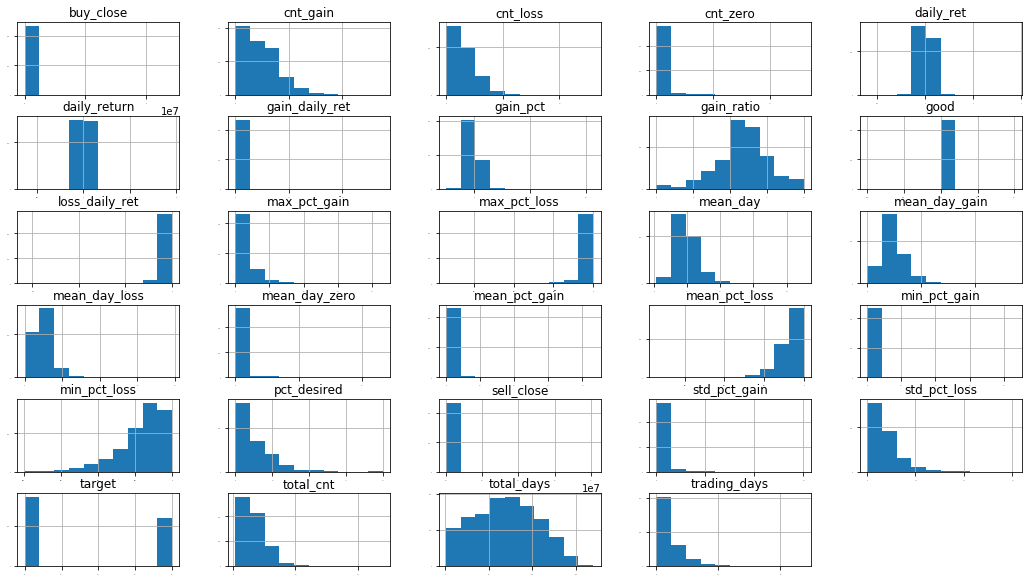

In [26]:
# histograms
trades_stats_df.hist(sharex=False, sharey=False, xlabelsize=1, 
                     ylabelsize=1, figsize=(18,10))    
plt.show()

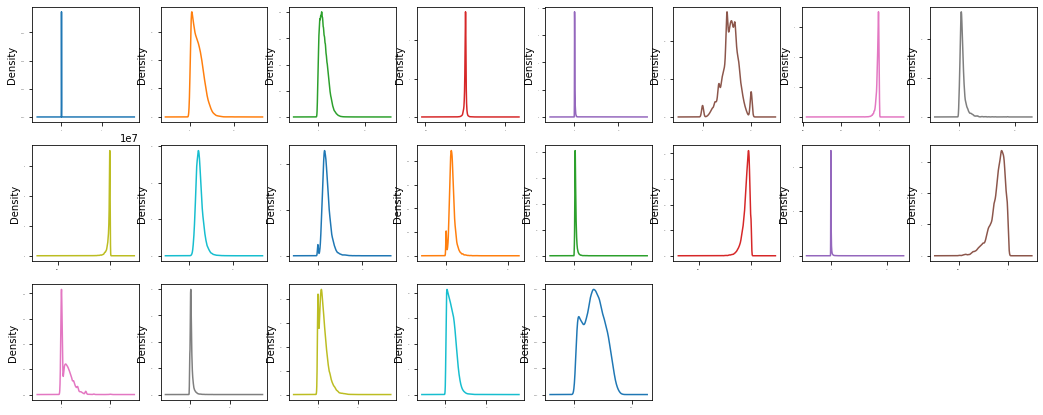

In [27]:
# density
trades_stats_df[used_cols].plot(kind='density', subplots=True, layout=(8,8), 
                     sharex=False, legend=False, fontsize=1, figsize=(18,20))
plt.show()

In [28]:
# eliminate string fields and fields that it should not have
cor_exclude = ['ticker', 'buy_date', 'sell_date', 'buy_close', 'sell_close',
              'trading_days', 'gain_pct', 'daily_return']
used_cols = exclude_tickers(trades_stats_df.columns, cor_exclude)
print(len(used_cols), used_cols)

24 ['cnt_gain', 'cnt_loss', 'cnt_zero', 'daily_ret', 'gain_daily_ret', 'gain_ratio', 'good', 'loss_daily_ret', 'max_pct_gain', 'max_pct_loss', 'mean_day', 'mean_day_gain', 'mean_day_loss', 'mean_day_zero', 'mean_pct_gain', 'mean_pct_loss', 'min_pct_gain', 'min_pct_loss', 'pct_desired', 'std_pct_gain', 'std_pct_loss', 'target', 'total_cnt', 'total_days']


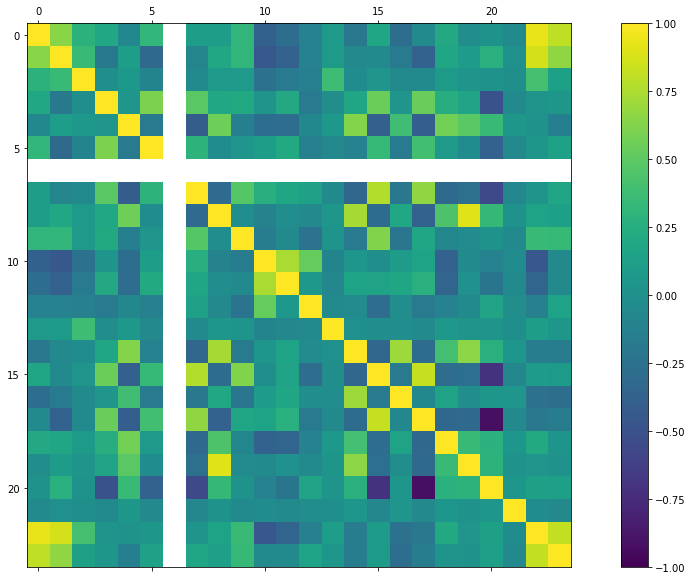

In [29]:
plot_corr_matrix(trades_stats_df[used_cols])

In [30]:
#used_cols=list(trades_stats_df[used_cols].columns)
print_used_cols(used_cols)

i=00	col=cnt_gain
i=01	col=cnt_loss
i=02	col=cnt_zero
i=03	col=daily_ret
i=04	col=gain_daily_ret
i=05	col=gain_ratio
i=06	col=good
i=07	col=loss_daily_ret
i=08	col=max_pct_gain
i=09	col=max_pct_loss
i=10	col=mean_day
i=11	col=mean_day_gain
i=12	col=mean_day_loss
i=13	col=mean_day_zero
i=14	col=mean_pct_gain
i=15	col=mean_pct_loss
i=16	col=min_pct_gain
i=17	col=min_pct_loss
i=18	col=pct_desired
i=19	col=std_pct_gain
i=20	col=std_pct_loss
i=21	col=target
i=22	col=total_cnt
i=23	col=total_days


In [31]:
print_target_corr(used_cols)

mean_pct_loss    -0.072
loss_daily_ret   -0.072
min_pct_loss     -0.062
total_days       -0.060
gain_ratio       -0.055
max_pct_loss     -0.049
cnt_gain         -0.047
daily_ret        -0.046
mean_day_gain    -0.040
mean_day         -0.031
total_cnt        -0.027
mean_day_loss    -0.014
mean_day_zero    -0.006
cnt_zero         -0.003
cnt_loss          0.006
max_pct_gain      0.030
std_pct_gain      0.030
min_pct_gain      0.044
pct_desired       0.049
mean_pct_gain     0.049
std_pct_loss      0.052
gain_daily_ret    0.058
target            1.000
good                NaN
Name: target, dtype: float64


In [32]:
keep = []
for col in used_cols:
    if col == target:
        continue
    correlation = trades_stats_df.corr()["target"][col]
    if correlation > 0.1 or correlation < -0.1:
        keep.append(col)
print(len(keep), keep)

0 []


In [33]:
print_target_corr(keep)

target    1.0
Name: target, dtype: float64


In [34]:
keep_cols = keep
sorted(keep_cols)

[]

In [35]:
# orig_keep = keep_cols.copy()
# for i, col in enumerate(orig_keep):
#     print(f'i={i} col={col}')
#     col2 = f'{str(col)}_sq'
#     #print(f"col2={col2}")
#     trades_stats_df[col2] = trades_stats_df[col] * trades_stats_df[col]
    
#     col_log = f'{str(col)}_log'
#     #print(f"col_log={col_log}")
#     trades_stats_df[col_log] = np.log(trades_stats_df[col])
    
#     col_logp1 = f'{str(col)}_logp1'
#     #print(f"col_log={col_log}")
#     trades_stats_df[col_logp1] = np.log(1+trades_stats_df[col])
    
#     col_sqrt = f'{str(col)}_sqrt'
#     #print(f"col_log={col_sqrt}")
#     trades_stats_df[col_sqrt] = np.sqrt(trades_stats_df[col])
    
#     keep_cols += [col2, col_log, col_logp1, col_sqrt]
#     #print(len(keep_cols), keep_cols, "\n")

# print(len(keep_cols), keep_cols, "\n")

In [36]:
# all_cols = keep_cols + [target]
# df = trades_stats_df[sorted(all_cols)]
# print(df.corr()["target"])

In [37]:
# keep_cols = ['cnt_gain_sqrt', 'gain_daily_ret_log','loss_daily_ret', 'max_pct_loss',
#             'mean_pct_gain_log', 'mean_pct_loss', 'min_pct_loss', 'total_cnt_sqrt', 
#              'total_days_sqrt']

In [38]:
# corr_above(trades_stats_df, 0.5, keep_cols)

In [39]:
# corr_below(trades_stats_df, -0.5, keep_cols)

In [40]:
# all_cols = keep_cols + [target]
# df = trades_stats_df[sorted(all_cols)]
# print(df.corr()["target"].sort_values())

In [41]:
#
# Leave columns in as otherwise not enough columns...
#
# cor_exclude = ['total_cnt', 'std_pct_loss', 'gain_daily_ret',
#                'min_pct_loss', 'total_days']
# keep_cols = exclude_tickers(keep, cor_exclude)
# print(len(keep_cols), keep_cols)

In [42]:
# Test options and evaluation metric
num_folds = 5
seed = 7
scoring = 'accuracy'

In [43]:
def run_cat_models(num_folds=5, seed=7, scoring='accuracy'):
    models = []
    models.append(('LR', LogisticRegression(class_weight='balanced', solver='liblinear')))
    models.append(('LDA', LinearDiscriminantAnalysis())) 
    models.append(('KNN', KNeighborsClassifier())) 
    models.append(('CART', DecisionTreeClassifier())) 
    models.append(('NB', GaussianNB()))
    #models.append(('SVM', SVC(gamma='auto')))
    
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) 
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
     
    return results, names

In [44]:
# Compare Algorithms
def algo_comparison(results, names):
    fig = plt.figure(figsize=(10,8)) 
    fig.suptitle('Algorithm Comparison') 
    ax = fig.add_subplot(111) 
    plt.boxplot(results) 
    ax.set_xticklabels(names) 
    plt.show()

In [45]:
def run_std_cat_models(num_folds=5, seed=7, scoring='accuracy'):
    
    LRpipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('LR', LogisticRegression(class_weight='balanced', solver='liblinear'))
        ])
    
    LDApipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('LDA', LinearDiscriminantAnalysis())
        ])
    
    KNNpipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('KNN', KNeighborsClassifier())
        ])
    
    CARTpipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('CART', DecisionTreeClassifier())
        ])
    
    NBpipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('NB', GaussianNB())
        ])
    
    SVMpipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('SVM', SVC(gamma='auto'))
        ])
        
    pipelines = []
    pipelines.append(('ScaledLR',   LRpipe))
    pipelines.append(('ScaledLDA',  LDApipe))
    pipelines.append(('ScaledKNN',  KNNpipe))
    pipelines.append(('ScaledCART', CARTpipe))
    pipelines.append(('ScaledNB',   NBpipe))   
    #pipelines.append(('ScaledSVM',  SVMpipe))

    results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) 
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return results, names

In [46]:
def tune_std_KNN(num_folds=5, seed=7, scoring='accuracy',
                neighbors=[1,3,5,7,9,11,13,15,17,19,21]):

    scaler = StandardScaler().fit(X_train) 
    rescaledX = scaler.transform(X_train)
     
    param_grid = dict(n_neighbors=neighbors) 
    
    model = KNeighborsClassifier()
    kfold = KFold(n_splits=num_folds, random_state=seed)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold,
                        iid=True)
    grid_result = grid.fit(rescaledX, y_train)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return means, stds, params

In [47]:
# Tune scaled SVM

def tune_std_SVM(num_folds=5, seed=7, scoring='accuracy',
                c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
                kernel_values = ['linear', 'poly', 'rbf', 'sigmoid'] ):
    
    scaler = StandardScaler().fit(X_train)
    rescaledX = scaler.transform(X_train)
    
    param_grid = dict(C=c_values, kernel=kernel_values)
    model = SVC(gamma='auto')
    kfold = KFold(n_splits=num_folds, random_state=seed)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold,
                        iid=True)
    grid_result = grid.fit(rescaledX, y_train)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    means  = grid_result.cv_results_['mean_test_score']
    stds   = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return means, stds, params

In [48]:
# Results: 5/8/2020:
#
# Best: 0.594664 using {'C': 2.0, 'kernel': 'rbf'}
# 0.591888 (0.002338) with: {'C': 0.1, 'kernel': 'linear'}
# 0.592294 (0.003304) with: {'C': 0.1, 'kernel': 'poly'}
# 0.592016 (0.001413) with: {'C': 0.1, 'kernel': 'rbf'}
# 0.530843 (0.010084) with: {'C': 0.1, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 0.3, 'kernel': 'linear'}
# 0.592593 (0.003091) with: {'C': 0.3, 'kernel': 'poly'}
# 0.593746 (0.002652) with: {'C': 0.3, 'kernel': 'rbf'}
# 0.527767 (0.009341) with: {'C': 0.3, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 0.5, 'kernel': 'linear'}
# 0.592870 (0.003114) with: {'C': 0.5, 'kernel': 'poly'}
# 0.593960 (0.003546) with: {'C': 0.5, 'kernel': 'rbf'}
# 0.527425 (0.009290) with: {'C': 0.5, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 0.7, 'kernel': 'linear'}
# 0.592657 (0.002934) with: {'C': 0.7, 'kernel': 'poly'}
# 0.593511 (0.003298) with: {'C': 0.7, 'kernel': 'rbf'}
# 0.527276 (0.009343) with: {'C': 0.7, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 0.9, 'kernel': 'linear'}
# 0.592849 (0.002925) with: {'C': 0.9, 'kernel': 'poly'}
# 0.593191 (0.003694) with: {'C': 0.9, 'kernel': 'rbf'}
# 0.527511 (0.009594) with: {'C': 0.9, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 1.0, 'kernel': 'linear'}
# 0.592828 (0.002897) with: {'C': 1.0, 'kernel': 'poly'}
# 0.593468 (0.003644) with: {'C': 1.0, 'kernel': 'rbf'}
# 0.527425 (0.009672) with: {'C': 1.0, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 1.3, 'kernel': 'linear'}
# 0.593319 (0.002833) with: {'C': 1.3, 'kernel': 'poly'}
# 0.593789 (0.004000) with: {'C': 1.3, 'kernel': 'rbf'}
# 0.527062 (0.009412) with: {'C': 1.3, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 1.5, 'kernel': 'linear'}
# 0.593447 (0.002823) with: {'C': 1.5, 'kernel': 'poly'}
# 0.594237 (0.003885) with: {'C': 1.5, 'kernel': 'rbf'}
# 0.526870 (0.009633) with: {'C': 1.5, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 1.7, 'kernel': 'linear'}
# 0.593340 (0.002915) with: {'C': 1.7, 'kernel': 'poly'}
# 0.594429 (0.004076) with: {'C': 1.7, 'kernel': 'rbf'}
# 0.526827 (0.009768) with: {'C': 1.7, 'kernel': 'sigmoid'}
# 0.591888 (0.002338) with: {'C': 2.0, 'kernel': 'linear'}
# 0.593362 (0.003147) with: {'C': 2.0, 'kernel': 'poly'}
# 0.594664 (0.003751) with: {'C': 2.0, 'kernel': 'rbf'}
# 0.526763 (0.009804) with: {'C': 2.0, 'kernel': 'sigmoid'}

In [49]:
# prepare the model
def finalize_model():
    scaler = StandardScaler().fit(X_train) 
    rescaledX = scaler.transform(X_train) 
    model = LogisticRegression(solver='liblinear') 
    model.fit(rescaledX, y_train)
    # estimate accuracy on validation dataset
    rescaledValidationX = scaler.transform(X_test) 
    predictions = model.predict(rescaledValidationX) 
    print(accuracy_score(y_test, predictions))

    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(f'sum(y_test)={sum(y_test)} sum(predictions)={sum(predictions)}')

In [50]:
def run():
    # Run category models without standardization (mean=0, stdev=1)
    results, names = run_cat_models()
    algo_comparison(results, names)

    # Run category models with standardization (mean=0, stdev=1)
    results, names = run_std_cat_models()
    algo_comparison(results, names)

    # Do grid seach for KNN list of neighbors
    #my_values = [1,3,5,7,9,11,13,15,17,19,21, 23, 25, 31]
    #means, stds, params = tune_std_KNN(neighbors=my_values)
    
    finalize_model()

In [51]:
# eliminate string fields and fields that contain future information
cor_exclude = ['ticker', 'buy_date', 'sell_date', 'buy_close', 'sell_close',
              'trading_days', 'gain_pct', 'daily_return', 'target', 'good']
used_cols = exclude_tickers(trades_stats_df.columns, cor_exclude)
print(len(used_cols), used_cols)

22 ['cnt_gain', 'cnt_loss', 'cnt_zero', 'daily_ret', 'gain_daily_ret', 'gain_ratio', 'loss_daily_ret', 'max_pct_gain', 'max_pct_loss', 'mean_day', 'mean_day_gain', 'mean_day_loss', 'mean_day_zero', 'mean_pct_gain', 'mean_pct_loss', 'min_pct_gain', 'min_pct_loss', 'pct_desired', 'std_pct_gain', 'std_pct_loss', 'total_cnt', 'total_days']


In [77]:
def filter_n_run(threshold):
    idx = trades_stats_df.total_cnt > threshold
    df = trades_stats_df.loc[idx].copy()
    
    df['target'] = 0
    idx = df.gain_pct < 0     
    df.loc[idx, 'target'] = 1
    
    print("sum(df,target=",sum(df.target))
    print("len(df)=",len(df))
    print("share=",sum(df.target)/len(df))

    X, y, X_train, X_test, y_train, y_test = split_data(df, used_cols, target)
    run()

sum(df,target= 14471
len(df)= 37201
share= 0.3889949194914115
LR: 0.555589 (0.002645)
LDA: 0.593032 (0.003439)
KNN: 0.543862 (0.003032)
CART: 0.541000 (0.005876)
NB: 0.588162 (0.002171)


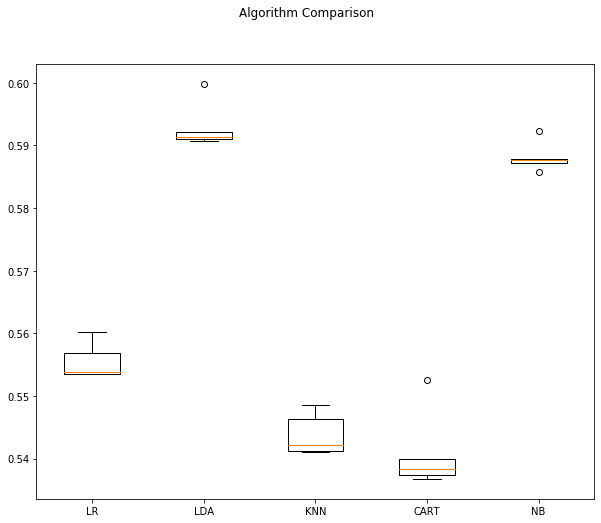

ScaledLR: 0.552556 (0.002297)
ScaledLDA: 0.593032 (0.003439)
ScaledKNN: 0.556251 (0.005690)
ScaledCART: 0.541406 (0.004905)
ScaledNB: 0.588504 (0.002201)


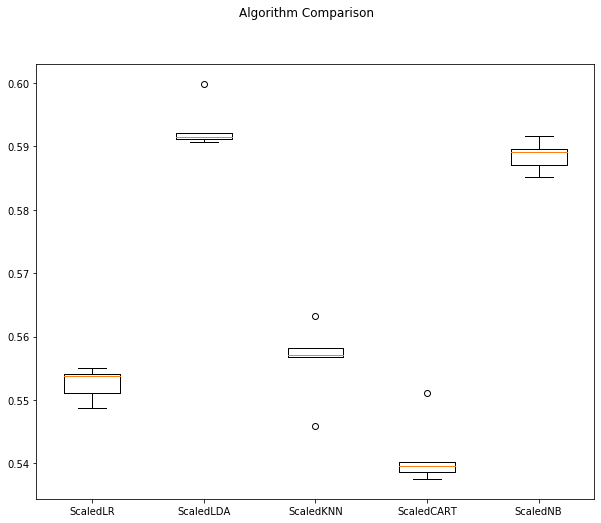

0.6029047415634344
[[6719  261]
 [4387  338]]
              precision    recall  f1-score   support

           0       0.60      0.96      0.74      6980
           1       0.56      0.07      0.13      4725

    accuracy                           0.60     11705
   macro avg       0.58      0.52      0.43     11705
weighted avg       0.59      0.60      0.49     11705

sum(y_test)=4725 sum(predictions)=599


In [80]:
filter_n_run(10)

share= 0.40739538301180733
LR: 0.550194 (0.005583)
LDA: 0.594793 (0.003378)
KNN: 0.550536 (0.003271)
CART: 0.540817 (0.006254)
NB: 0.587509 (0.003639)


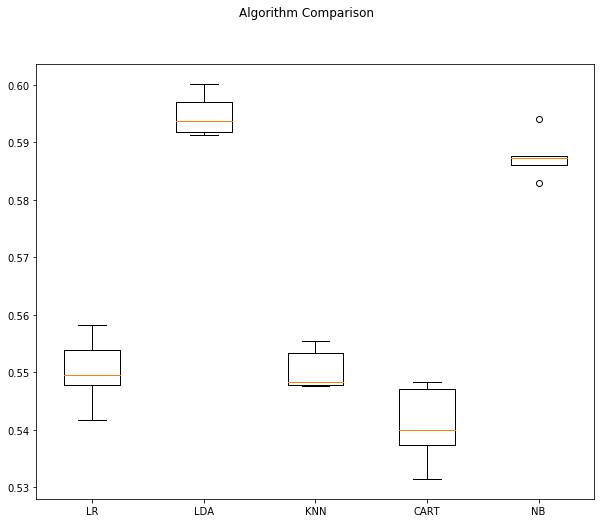

ScaledLR: 0.550579 (0.004998)
ScaledLDA: 0.594793 (0.003378)
ScaledKNN: 0.552714 (0.006971)
ScaledCART: 0.541116 (0.004708)
ScaledNB: 0.587509 (0.003736)


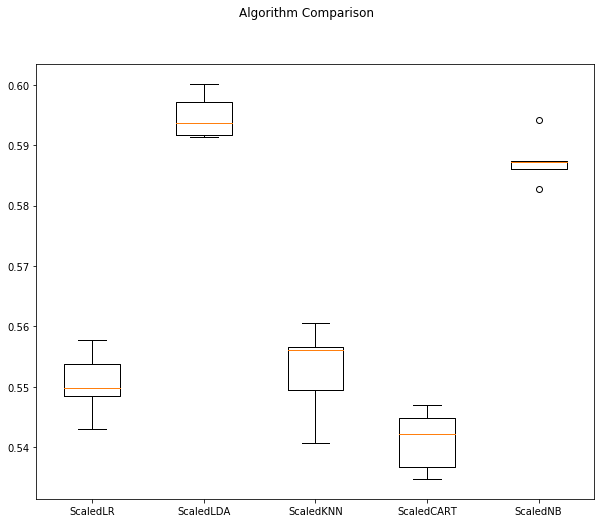

0.6001708671507903
[[6673  299]
 [4381  352]]
              precision    recall  f1-score   support

           0       0.60      0.96      0.74      6972
           1       0.54      0.07      0.13      4733

    accuracy                           0.60     11705
   macro avg       0.57      0.52      0.44     11705
weighted avg       0.58      0.60      0.49     11705

sum(y_test)=4733 sum(predictions)=651


In [52]:
trades_stats_df['target'] = 0
idx = (trades_stats_df.gain_pct < 0) # & (trades_stats_df.gain_pct < 5)
trades_stats_df.loc[idx, 'target'] = 1
print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, used_cols, target)
run()

share= 0.32518838747159234
LR: 0.572728 (0.005421)
LDA: 0.670639 (0.001803)
KNN: 0.631125 (0.002734)
CART: 0.620723 (0.005255)
NB: 0.560425 (0.005525)


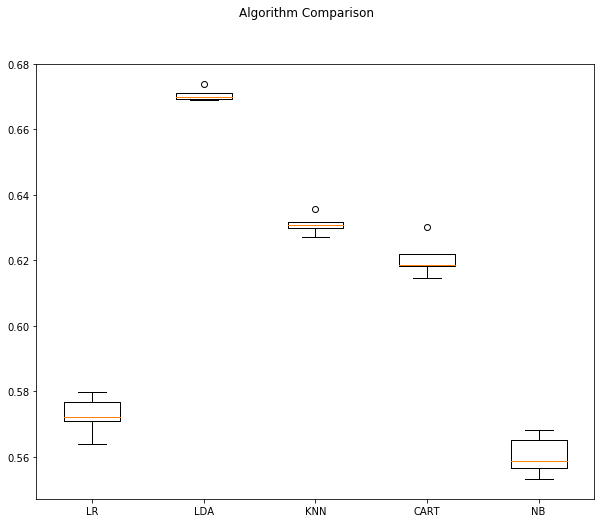

ScaledLR: 0.572536 (0.004983)
ScaledLDA: 0.670639 (0.001803)
ScaledKNN: 0.633944 (0.004122)
ScaledCART: 0.620958 (0.004374)
ScaledNB: 0.560425 (0.005550)


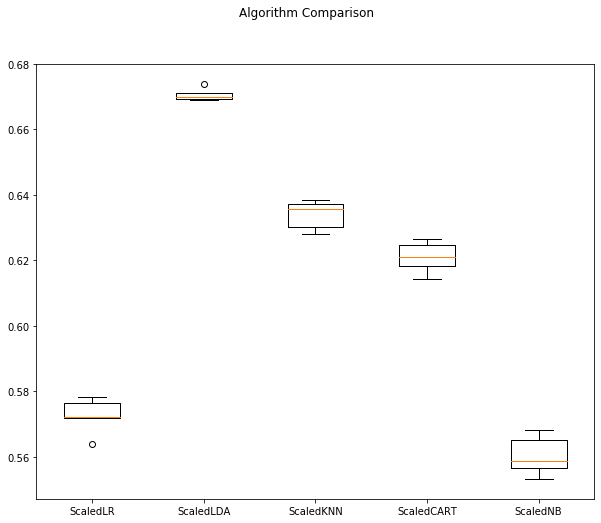

0.6761213156770611
[[7594  325]
 [3466  320]]
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      7919
           1       0.50      0.08      0.14      3786

    accuracy                           0.68     11705
   macro avg       0.59      0.52      0.47     11705
weighted avg       0.63      0.68      0.59     11705

sum(y_test)=3786 sum(predictions)=645


In [53]:
trades_stats_df['target'] = 0
idx = (trades_stats_df.gain_pct < 0) & (trades_stats_df.total_cnt > 5)
trades_stats_df.loc[idx, 'target'] = 1
print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, used_cols, target)
run()

share= 0.2472703039830494
LR: 0.659938 (0.002428)
LDA: 0.740741 (0.003614)
KNN: 0.720193 (0.003761)
CART: 0.712077 (0.005769)
NB: 0.633346 (0.005190)


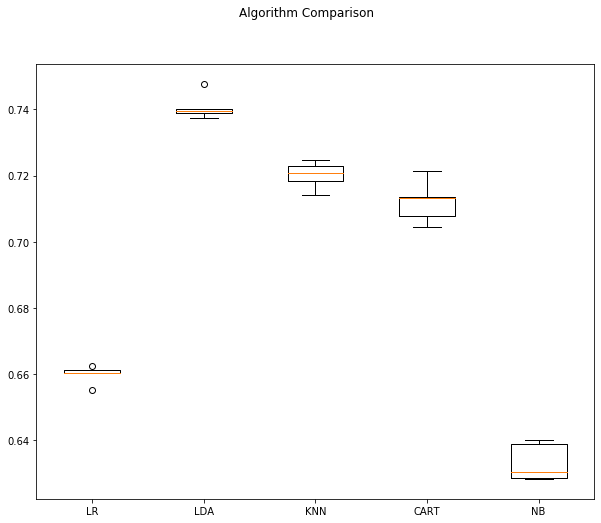

ScaledLR: 0.659896 (0.002684)
ScaledLDA: 0.740741 (0.003614)
ScaledKNN: 0.721581 (0.003421)
ScaledCART: 0.712012 (0.004894)
ScaledNB: 0.633410 (0.005154)


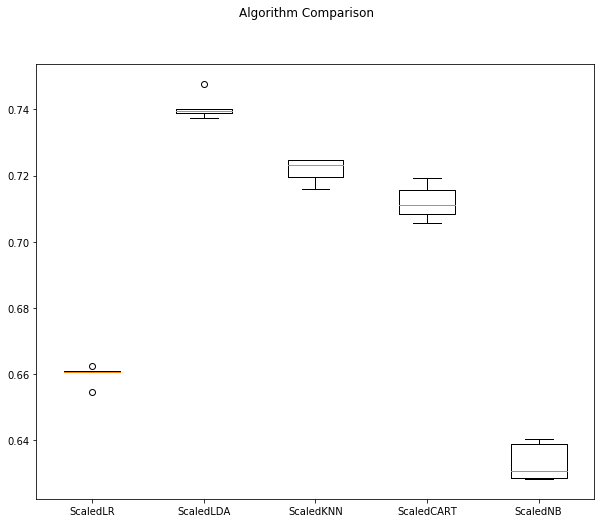

0.7524134985049125
[[8344  480]
 [2418  463]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      8824
           1       0.49      0.16      0.24      2881

    accuracy                           0.75     11705
   macro avg       0.63      0.55      0.55     11705
weighted avg       0.71      0.75      0.70     11705

sum(y_test)=2881 sum(predictions)=943


In [54]:
trades_stats_df['target'] = 0
idx = (trades_stats_df.gain_pct < 0) & (trades_stats_df.total_cnt > 10)
trades_stats_df.loc[idx, 'target'] = 1
print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, used_cols, target)
run()

In [55]:
# c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
# kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

# means, stds, params = tune_std_SVM(c_values=c_values, kernel_values = kernel_values)

In [56]:
def select_best(df, col, best_col, best_score):
    correlation = df.corr()["target"][col]
    if correlation > best_score:
        best_score = correlation
        best_col = col
    else:
        del df[col]
    return df, best_col, best_score

In [57]:
def clean_up_columns(df, used_cols):
    cols=list(df.columns)
    for col in cols:
        to_del = False
        to_del |= '_sq' in col
        to_del |= '_log' in col
        to_del |= '_logp1' in col
        if to_del == True:
            print(f'deleting {col}')
            del df[col]
            used_cols = exclude_tickers(used_cols, [col])
    return df, used_cols

In [58]:
trades_stats_df, used_cols = clean_up_columns(trades_stats_df, used_cols)
trades_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58523 entries, 0 to 58522
Data columns (total 32 columns):
ticker            58523 non-null object
buy_date          58523 non-null object
buy_close         58523 non-null float64
sell_date         58523 non-null object
sell_close        58522 non-null float64
gain_pct          58522 non-null float64
trading_days      58523 non-null int64
daily_return      58522 non-null float64
cnt_gain          58523 non-null int64
min_pct_gain      58523 non-null float64
max_pct_gain      58523 non-null float64
std_pct_gain      58523 non-null float64
mean_pct_gain     58523 non-null float64
mean_day_gain     58523 non-null float64
gain_daily_ret    58523 non-null float64
cnt_loss          58523 non-null int64
min_pct_loss      58523 non-null float64
max_pct_loss      58523 non-null float64
std_pct_loss      58523 non-null float64
mean_pct_loss     58523 non-null float64
mean_day_loss     58523 non-null float64
loss_daily_ret    58523 non-null float6

In [59]:
print(used_cols)

['cnt_gain', 'cnt_loss', 'cnt_zero', 'daily_ret', 'gain_daily_ret', 'gain_ratio', 'loss_daily_ret', 'max_pct_gain', 'max_pct_loss', 'mean_day', 'mean_day_gain', 'mean_day_loss', 'mean_day_zero', 'mean_pct_gain', 'mean_pct_loss', 'min_pct_gain', 'min_pct_loss', 'pct_desired', 'std_pct_gain', 'std_pct_loss', 'total_cnt', 'total_days']


In [60]:
# orig_used_cols = exclude_tickers(orig_used_cols, ['mean_pct_loss_logp1']) + ['mean_pct_loss']
# orig_used_cols = sorted(orig_used_cols)
# used_cols = orig_used_cols
# orig_used_cols, used_cols

In [61]:
trades_stats_df, used_cols = clean_up_columns(trades_stats_df, used_cols)

trades_stats_df['target'] = 0
idx = (trades_stats_df.gain_pct < 0) # & (trades_stats_df.total_cnt > 10)
trades_stats_df.loc[idx, 'target'] = 1

orig_used_cols = used_cols.copy()
print(f'orig_used_cols={orig_used_cols}')
best_keep = []
cols_dict = {}

for i, col in enumerate(orig_used_cols):

    col2 = f'{str(col)}_sq'
    col_log = f'{str(col)}_log'
    col_logp1 = f'{str(col)}_logp1'
    col_sqrt = f'{str(col)}_sqrt'
    cols = [col2, col_log, col_logp1, col_sqrt]
    
    trades_stats_df[col2] = trades_stats_df[col] * trades_stats_df[col]
    trades_stats_df[col_log] = np.log(trades_stats_df[col])
    trades_stats_df[col_logp1] = np.log(1+trades_stats_df[col])
    trades_stats_df[col_sqrt] = np.sqrt(trades_stats_df[col])
    
    best_score = trades_stats_df.corr()["target"][col]
    best_col   = col
    
    for c in cols:
        trades_stats_df, best_col, best_score = \
              select_best(trades_stats_df, c, best_col, best_score)
    
    best_keep += [best_col]
    cols_dict[col] = best_col
    print(f'i={i} col={col} best_col={best_col} best_score={best_score}')
    
print(len(best_keep), best_keep, "\n")

del trades_stats_df['mean_pct_loss_logp1']
best_keep = exclude_tickers(best_keep, ['mean_pct_loss_logp1']) + ['mean_pct_loss']
used_cols = exclude_tickers(best_keep, ['mean_pct_loss']) + ['mean_pct_loss']
cols_dict['mean_pct_loss'] = 'mean_pct_loss'

trades_stats_df.info()
print(orig_used_cols,"\n", used_cols)

orig_used_cols=['cnt_gain', 'cnt_loss', 'cnt_zero', 'daily_ret', 'gain_daily_ret', 'gain_ratio', 'loss_daily_ret', 'max_pct_gain', 'max_pct_loss', 'mean_day', 'mean_day_gain', 'mean_day_loss', 'mean_day_zero', 'mean_pct_gain', 'mean_pct_loss', 'min_pct_gain', 'min_pct_loss', 'pct_desired', 'std_pct_gain', 'std_pct_loss', 'total_cnt', 'total_days']
i=0 col=cnt_gain best_col=cnt_gain_sq best_score=-0.025543751330667316
i=1 col=cnt_loss best_col=cnt_loss_sq best_score=0.018539158377132697
i=2 col=cnt_zero best_col=cnt_zero_sqrt best_score=-0.0009997315941155588
i=3 col=daily_ret best_col=daily_ret_sq best_score=0.039820028434768596
i=4 col=gain_daily_ret best_col=gain_daily_ret_logp1 best_score=0.06793452480850505
i=5 col=gain_ratio best_col=gain_ratio_sq best_score=-0.04430105621026628
i=6 col=loss_daily_ret best_col=loss_daily_ret_sq best_score=0.03244405273217851
i=7 col=max_pct_gain best_col=max_pct_gain best_score=0.029775768650424292
i=8 col=max_pct_loss best_col=max_pct_loss_sq bes

In [62]:
cols_dict

{'cnt_gain': 'cnt_gain_sq',
 'cnt_loss': 'cnt_loss_sq',
 'cnt_zero': 'cnt_zero_sqrt',
 'daily_ret': 'daily_ret_sq',
 'gain_daily_ret': 'gain_daily_ret_logp1',
 'gain_ratio': 'gain_ratio_sq',
 'loss_daily_ret': 'loss_daily_ret_sq',
 'max_pct_gain': 'max_pct_gain',
 'max_pct_loss': 'max_pct_loss_sq',
 'mean_day': 'mean_day_sq',
 'mean_day_gain': 'mean_day_gain_sq',
 'mean_day_loss': 'mean_day_loss_sq',
 'mean_day_zero': 'mean_day_zero_logp1',
 'mean_pct_gain': 'mean_pct_gain',
 'mean_pct_loss': 'mean_pct_loss',
 'min_pct_gain': 'min_pct_gain_logp1',
 'min_pct_loss': 'min_pct_loss_sq',
 'pct_desired': 'pct_desired_log',
 'std_pct_gain': 'std_pct_gain_log',
 'std_pct_loss': 'std_pct_loss_log',
 'total_cnt': 'total_cnt_sq',
 'total_days': 'total_days_sq'}

In [63]:
len(used_cols), len(best_keep)

(22, 22)

In [64]:
for col in list(trades_stats_df.columns):
    cnt = sum(trades_stats_df[col].isna())
    if cnt > 0:
        print(f'col={col}\tcnt={cnt}')

col=sell_close	cnt=1
col=gain_pct	cnt=1
col=daily_return	cnt=1


In [65]:
len_b4 = len(trades_stats_df)
trades_stats_df = trades_stats_df.dropna()
len_after = len(trades_stats_df)
len_b4, len_after, len_b4 - len_after

(58523, 58522, 1)

In [66]:
# Unsure what's wrong. Need to test and probably do 
# column by column to see where it goes wrong...
#

# trades_stats_df['target'] = 0
# idx = (trades_stats_df.gain_pct < 0) #& (trades_stats_df.total_cnt > 10)
# trades_stats_df.loc[idx, 'target'] = 1
# print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

# #used_cols = best_keep
# orig_len = len(orig_used_cols)
# for i, col in enumerate(orig_used_cols):
#     new_col = cols_dict[col]
#     used_cols = exclude_tickers(orig_used_cols, [col]) + [new_col]
#     print(f'i={i:02d} of {orig_len-1} col={col} -> new_col={new_col}\n  {used_cols}\n')

#     X, y, X_train, X_test, y_train, y_test = \
#          split_data(trades_stats_df, used_cols, target)
#     run()


In [67]:
cols=['pct_desired', 'pct_desired_log', 'std_pct_gain', 'std_pct_gain_log', 
      'std_pct_loss', 'std_pct_loss_log']
trades_stats_df[cols].describe()

,pct_desired,pct_desired_log,std_pct_gain,std_pct_gain_log,std_pct_loss,std_pct_loss_log
count,58522.000,5.852e+04,58522.000,5.852e+04,58522.000,5.852e+04
mean,11.122,-inf,10.993,-inf,6.932,-inf
std,12.398,NaN,12.683,NaN,5.931,NaN
min,0.000,-inf,0.000,-inf,0.000,-inf
25%,0.000,-inf,4.986,1.607e+00,2.790,1.026e+00
50%,8.330,2.120e+00,7.938,2.072e+00,5.700,1.740e+00
75%,17.650,2.871e+00,12.904,2.558e+00,9.656,2.268e+00
max,100.000,4.605e+00,300.669,5.706e+00,60.953,4.110e+00


used_cols=['cnt_gain_sq', 'cnt_loss_sq', 'cnt_zero_sqrt', 'daily_ret_sq', 'gain_daily_ret_logp1', 'gain_ratio_sq', 'loss_daily_ret_sq', 'max_pct_gain', 'max_pct_loss_sq', 'mean_day_gain_sq', 'mean_day_loss_sq', 'mean_day_sq', 'mean_day_zero_logp1', 'mean_pct_gain', 'mean_pct_loss', 'min_pct_gain_logp1', 'min_pct_loss_sq', 'total_cnt_sq', 'total_days_sq', 'pct_desired', 'std_pct_gain', 'std_pct_loss']
share= 0.407402344417484
LR: 0.555589 (0.002645)
LDA: 0.593032 (0.003439)
KNN: 0.543862 (0.003032)
CART: 0.538373 (0.004199)
NB: 0.588162 (0.002171)


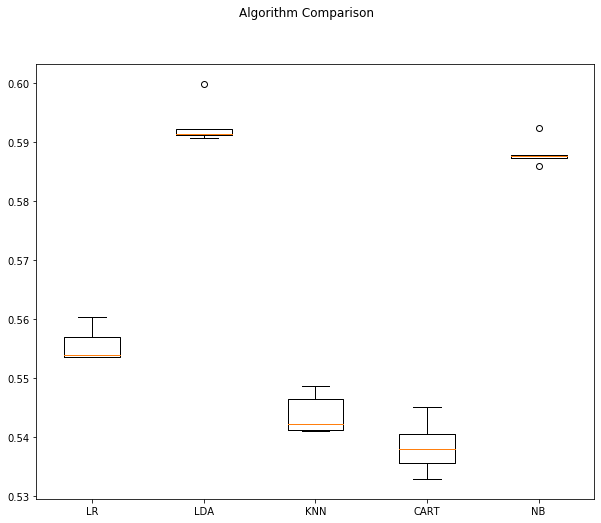

ScaledLR: 0.552556 (0.002297)
ScaledLDA: 0.593032 (0.003439)
ScaledKNN: 0.556251 (0.005690)
ScaledCART: 0.539654 (0.004896)
ScaledNB: 0.588504 (0.002201)


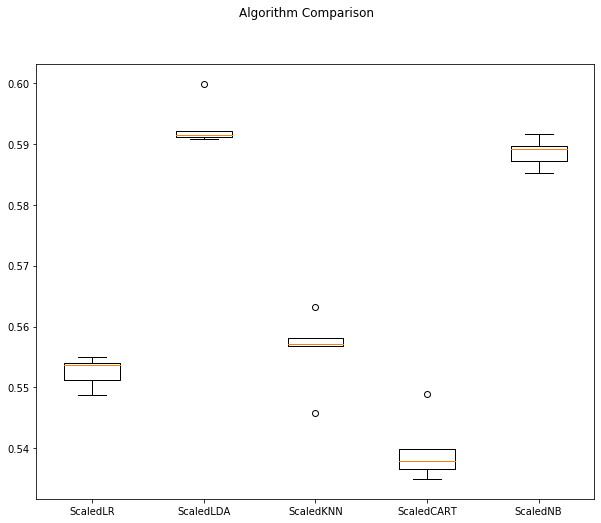

0.6029047415634344
[[6719  261]
 [4387  338]]
              precision    recall  f1-score   support

           0       0.60      0.96      0.74      6980
           1       0.56      0.07      0.13      4725

    accuracy                           0.60     11705
   macro avg       0.58      0.52      0.43     11705
weighted avg       0.59      0.60      0.49     11705

sum(y_test)=4725 sum(predictions)=599


In [68]:
cols_to_exclude =['pct_desired_log', 'std_pct_gain_log', 'std_pct_loss_log']
cols_to_add     =['pct_desired',     'std_pct_gain',     'std_pct_loss']

used_cols = exclude_tickers(best_keep, cols_to_exclude) + cols_to_add
print(f'used_cols={used_cols}')

trades_stats_df['target'] = 0
idx = (trades_stats_df.gain_pct < 0) #& (trades_stats_df.total_cnt > 5)
trades_stats_df.loc[idx, 'target'] = 1
print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, used_cols, target)
run()

In [69]:
# trades_stats_df['target'] = 0
# idx = (trades_stats_df.gain_pct < 0) & (trades_stats_df.total_cnt > 5)
# trades_stats_df.loc[idx, 'target'] = 1
# print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

# X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, best_keep, target)
# run()

In [70]:
# trades_stats_df['target'] = 0
# idx = (trades_stats_df.gain_pct < 0) & (trades_stats_df.total_cnt > 10)
# trades_stats_df.loc[idx, 'target'] = 1
# print("share=",sum(trades_stats_df.target)/len(trades_stats_df))

# X, y, X_train, X_test, y_train, y_test = split_data(trades_stats_df, best_keep, target)
# run()